# Multilayer Perceptron 

The goal is to create the architecture of a multilayer perceptron that classifies mushrooms (mushroom_dataset).

Dataset description - https://archive.ics.uci.edu/ml/datasets/Mushroom

It will have 2 hidden layers. The activation function will be sigmoid activation function and gradient descent without optimizers.

We have 2 output neurons according to the number of classes.


Importing all the necessary libraries.

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import math


plt.rcParams["figure.figsize"] = (20,6)
rng = np.random.default_rng(51)

A function for R^2

In [33]:
def R_square(y_pred, y):
  y_mean = np.mean(y)
  return 1 - np.sum(np.square(y - y_pred))/np.sum(np.square(y - y_mean))

A function for creating for batches for training.

In [34]:
def get_batches(data, batch_size):
  n = len(data)
  get_X = lambda z: z[0]
  get_y = lambda z: z[1]
  for i in range(0, n, batch_size):
    batch = data[i:i+batch_size]
    yield np.array([get_X(b) for b in batch]), np.array([get_y(b) for b in batch])

Our activation function will be sigmoid and out loss function will be binary cross entropy because the output is a case of true or false. We have either poisonous or non-poisonous mushrooms.

In [35]:
#defining our activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))


# Define loss functions
def binary_cross_entropy(y_pred, y_true):
    epsilon = 1e-15  # Small value to prevent log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_derivative(y_pred, y_true):
    # Ensure no division by zero
    eps = 1e-10  # small value to avoid log(0) issues
    y_pred = np.clip(y_pred, eps, 1 - eps)  # Clip values to avoid division by zero
    return - (y_true / y_pred) + (1 - y_true) / (1 - y_pred)


A class for our multilayer perceptron.

In [36]:
class MLP:
    #init
    def __init__(self, architecture, learning_rate = 0.01):
        self.depth = len(architecture) - 1
        self.learning_rate = learning_rate
        self.W = self._init_weights(architecture)
        self.b = self._init_biases(architecture)
        self.z = [None] * self.depth
        self.a = [None] * self.depth
        self.dz = [None] * self.depth
  
  
    # init weights
    def _init_weights(self, arch):
        return [np.random.randn(arch[i],arch[i+1]) * np.sqrt(2. / arch[i]) for i in range(self.depth)]

    #init biases
    def _init_biases(self, arch):
        return [np.zeros((1, arch[i+1])) for i in range(self.depth)]

    #our feedforward function
    def _feedforward(self, X):
        for i in range(self.depth):
            if i == 0:
                self.z[i] = np.dot(X, self.W[i]) + self.b[i]
                self.a[i] = sigmoid(self.z[i])
            else:
                self.z[i] = np.dot(self.a[i - 1],self.W[i]) + self.b[i]
                self.a[i] = sigmoid(self.z[i])
        
        return self.a[-1]


    #our backpropagation function
    def _backprop(self,X, y):
        self.dz[2] = binary_cross_entropy_derivative(self.a[-1],y) * sigmoid_derivative(self.z[2])
        self.dz[1] = self.dz[2].dot(self.W[2].T) * sigmoid_derivative(self.z[1])
        self.dz[0] = self.dz[1].dot(self.W[1].T) * sigmoid_derivative(self.z[0])

        for i in range(self.depth - 1, -1, -1):
            if i != 0:
                self.W[i] -= self.learning_rate * self.a[i-1].T.dot(self.dz[i])
                self.b[i] -= self.learning_rate * np.sum(self.dz[i],axis=0, keepdims=True)
            else:
                self.W[i] -= self.learning_rate * X.T.dot(self.dz[i])
                self.b[i] -= self.learning_rate * np.sum(self.dz[i],axis=0, keepdims=True)


    #a function for training
    def train(self, X, y, epochs, patience=500, tolerance=1e-1):
        best_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(epochs):
            output = self._feedforward(X)
            self._backprop(X, y)
            loss = binary_cross_entropy(output, y)
            
            if loss < best_loss - tolerance:
                best_loss = loss
                best_epoch = epoch
                patience_counter = 0
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                print(f"Early stopping on epoch {epoch}, loss = {loss}")
                print(f"Best loss & epoch {best_loss}, {best_epoch}")
                print
                break
            
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss}")
    


First we read the dataset.

In [37]:
df = pd.read_csv('2. Mushroom_dataset',delimiter=',',names=['class-label','cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment','gill-spacing','gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring','stalk-color-below-ring','veil-type','veil-color','ring-number','ring-type','spore-print-color','population','habitat'])
df.head()

class-label cap-shape cap-surface cap-color  bruises    odor  \
0      EDIBLE    CONVEX      SMOOTH     WHITE  BRUISES  ALMOND   
1      EDIBLE    CONVEX      SMOOTH     WHITE  BRUISES  ALMOND   
2      EDIBLE    CONVEX      SMOOTH     WHITE  BRUISES  ALMOND   
3      EDIBLE    CONVEX      SMOOTH     WHITE  BRUISES  ALMOND   
4      EDIBLE    CONVEX      SMOOTH     WHITE  BRUISES  ALMOND   

  gill-attachment gill-spacing gill-size gill-color stalk-shape stalk-root  \
0            FREE      CROWDED    NARROW      WHITE    TAPERING    BULBOUS   
1            FREE      CROWDED    NARROW      WHITE    TAPERING    BULBOUS   
2            FREE      CROWDED    NARROW       PINK    TAPERING    BULBOUS   
3            FREE      CROWDED    NARROW       PINK    TAPERING    BULBOUS   
4            FREE      CROWDED    NARROW      BROWN    TAPERING    BULBOUS   

  stalk-surface-above-ring stalk-surface-below-ring stalk-color-above-ring  \
0                   SMOOTH                   SMOOTH                  WHITE   
1                   SMOOTH                   SMOOTH                  WHITE   
2                   SMOOTH                   SMOOTH                  WHITE   
3                   SMOOTH                   SMOOTH                  WHITE   
4                   SMOOTH                   SMOOTH                  WHITE   

  stalk-color-below-ring veil-type veil-color ring-number ring-type  \
0                  WHITE   PARTIAL      WHITE         ONE   PENDANT   
1                  WHITE   PARTIAL      WHITE         ONE   PENDANT   
2                  WHITE   PARTIAL      WHITE         ONE   PENDANT   
3                  WHITE   PARTIAL      WHITE         ONE   PENDANT   
4                  WHITE   PARTIAL      WHITE         ONE   PENDANT   

  spore-print-color population habitat  
0            PURPLE    SEVERAL   WOODS  
1             BROWN    SEVERAL   WOODS  
2            PURPLE    SEVERAL   WOODS  
3             BROWN    SEVERAL   WOODS  
4            PURPLE    SEVERAL   WOODS

Some statistical information about the dataset.

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8416 entries, 0 to 8415
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class-label               8416 non-null   object
 1   cap-shape                 8416 non-null   object
 2   cap-surface               8416 non-null   object
 3   cap-color                 8416 non-null   object
 4   bruises                   8416 non-null   object
 5   odor                      8416 non-null   object
 6   gill-attachment           8416 non-null   object
 7   gill-spacing              8416 non-null   object
 8   gill-size                 8416 non-null   object
 9   gill-color                8416 non-null   object
 10  stalk-shape               8416 non-null   object
 11  stalk-root                8416 non-null   object
 12  stalk-surface-above-ring  8416 non-null   object
 13  stalk-surface-below-ring  8416 non-null   object
 14  stalk-color-above-ring  

Descriptive statistics.

In [39]:
df.describe()

class-label cap-shape cap-surface cap-color bruises  odor  \
count         8416      8416        8416      8416    8416  8416   
unique           2         6           4        10       2     9   
top         EDIBLE    CONVEX       SCALY     BROWN      NO  NONE   
freq          4488      3796        3268      2320    5040  3808   

       gill-attachment gill-spacing gill-size gill-color stalk-shape  \
count             8416         8416      8416       8416        8416   
unique               2            2         2         12           2   
top               FREE        CLOSE     BROAD       BUFF    TAPERING   
freq              8200         6824      5880       1728        4864   

       stalk-root stalk-surface-above-ring stalk-surface-below-ring  \
count        8416                     8416                     8416   
unique          5                        4                        4   
top       BULBOUS                   SMOOTH                   SMOOTH   
freq         3800                     5316                     5076   

       stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
count                    8416                   8416      8416       8416   
unique                      9                      9         1          4   
top                     WHITE                  WHITE   PARTIAL      WHITE   
freq                     4744                   4640      8416       8216   

       ring-number ring-type spore-print-color population habitat  
count         8416      8416              8416       8416    8416  
unique           3         5                 9          6       7  
top            ONE   PENDANT             WHITE    SEVERAL   WOODS  
freq          7768      3968              2424       4064    3160

In [40]:
df['class-label'].value_counts()

class-label
EDIBLE       4488
POISONOUS    3928
Name: count, dtype: int64

Let's check the density of our diferent features and label classes.

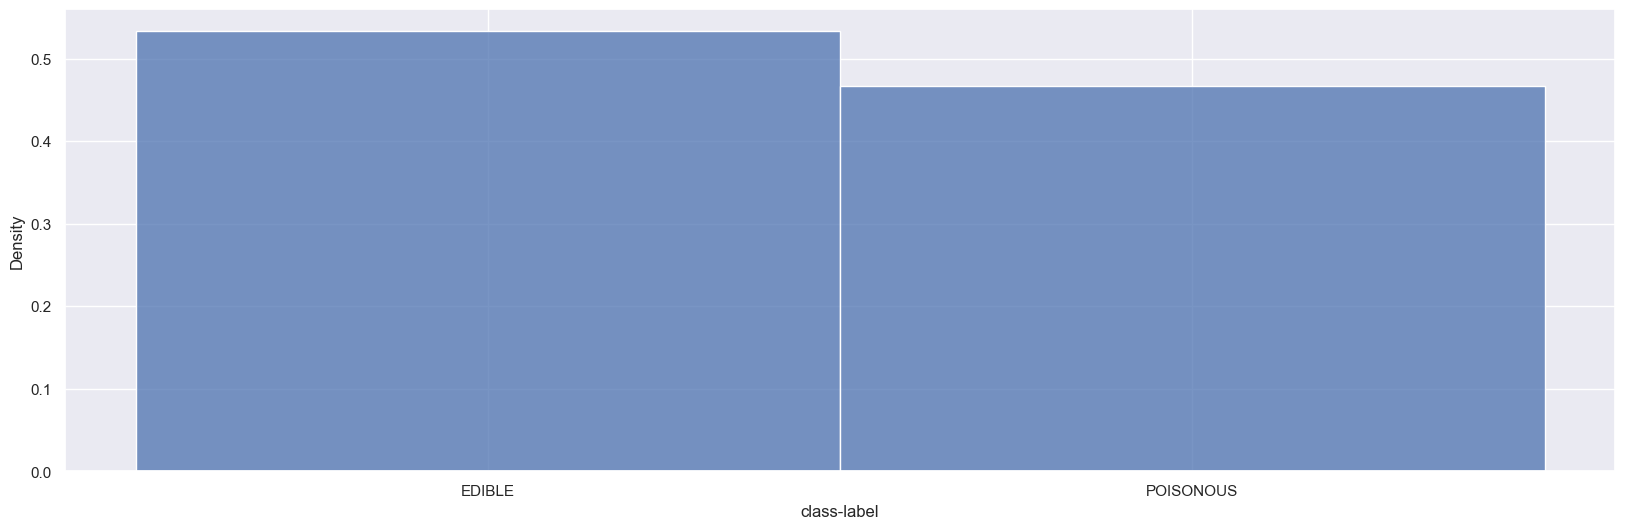

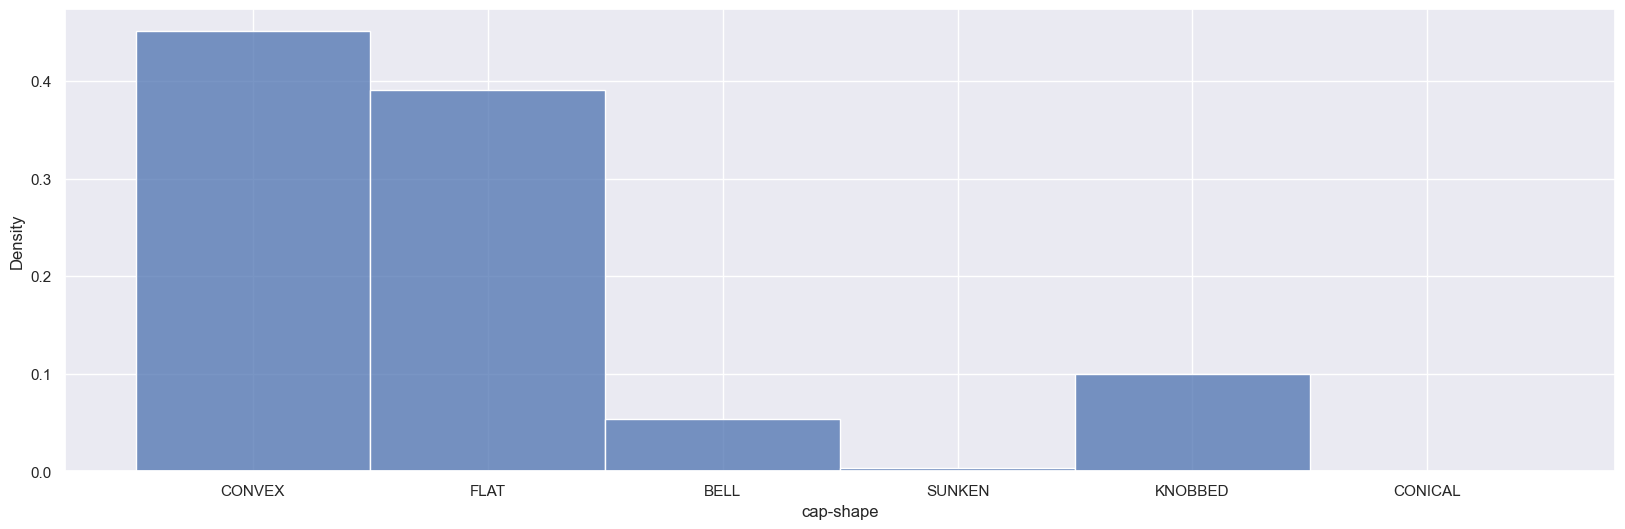

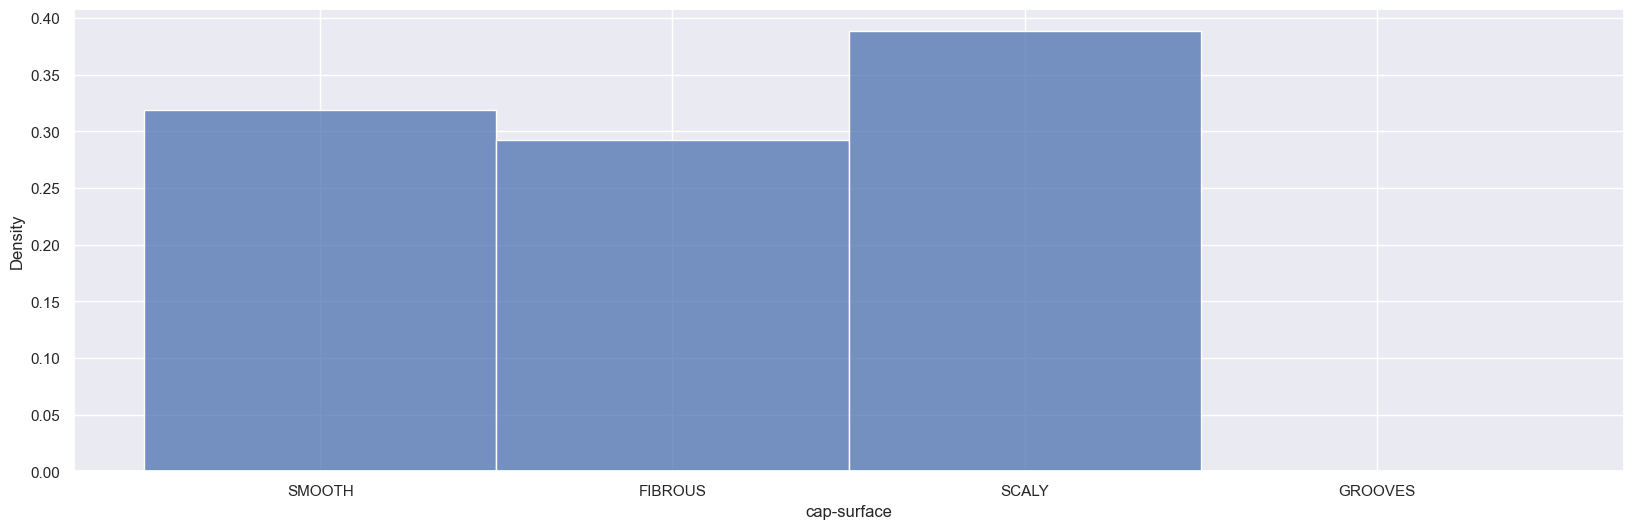

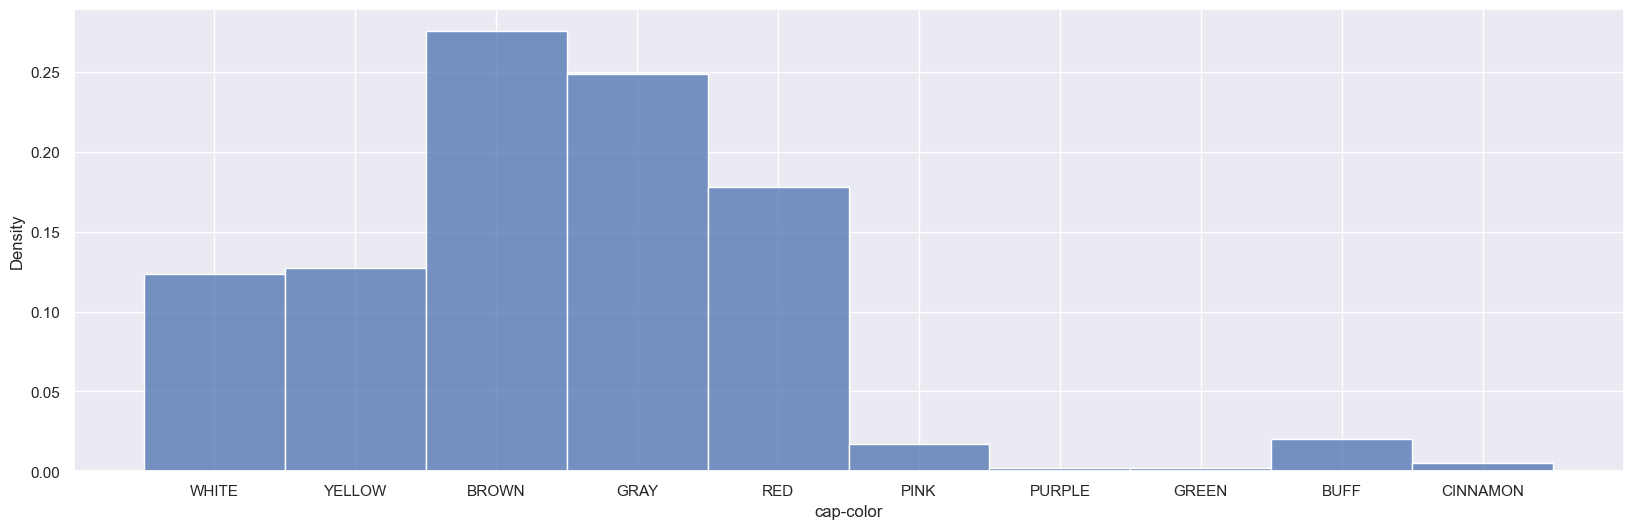

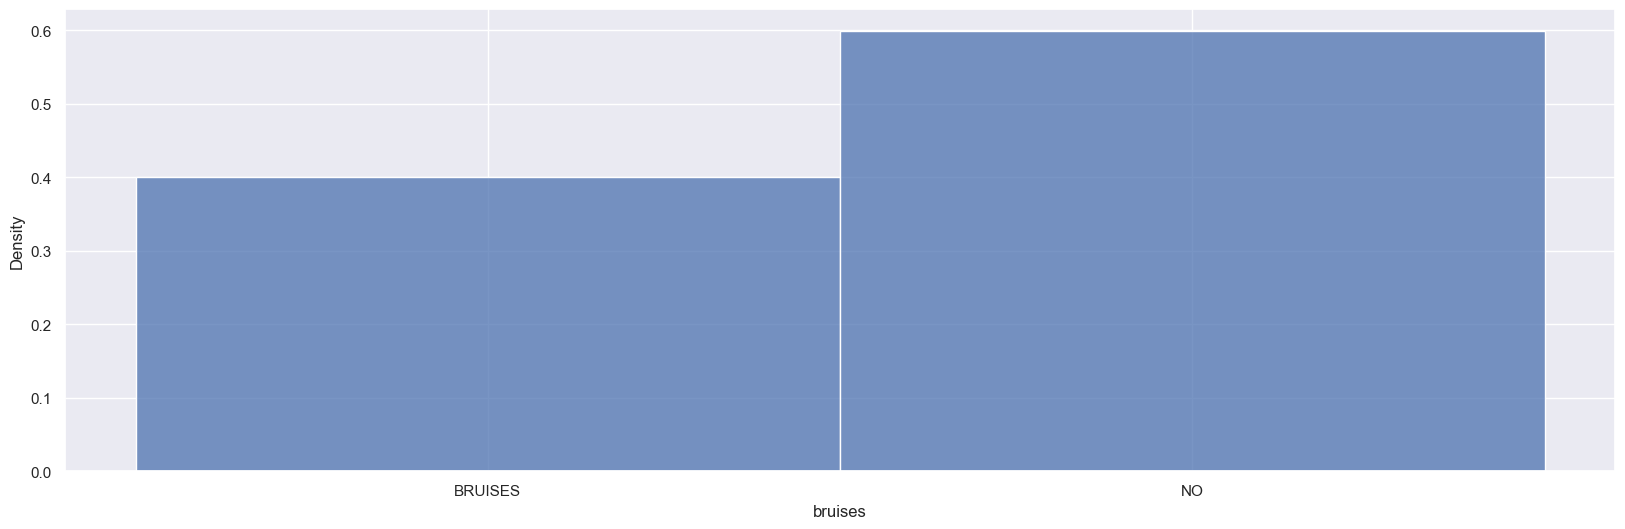

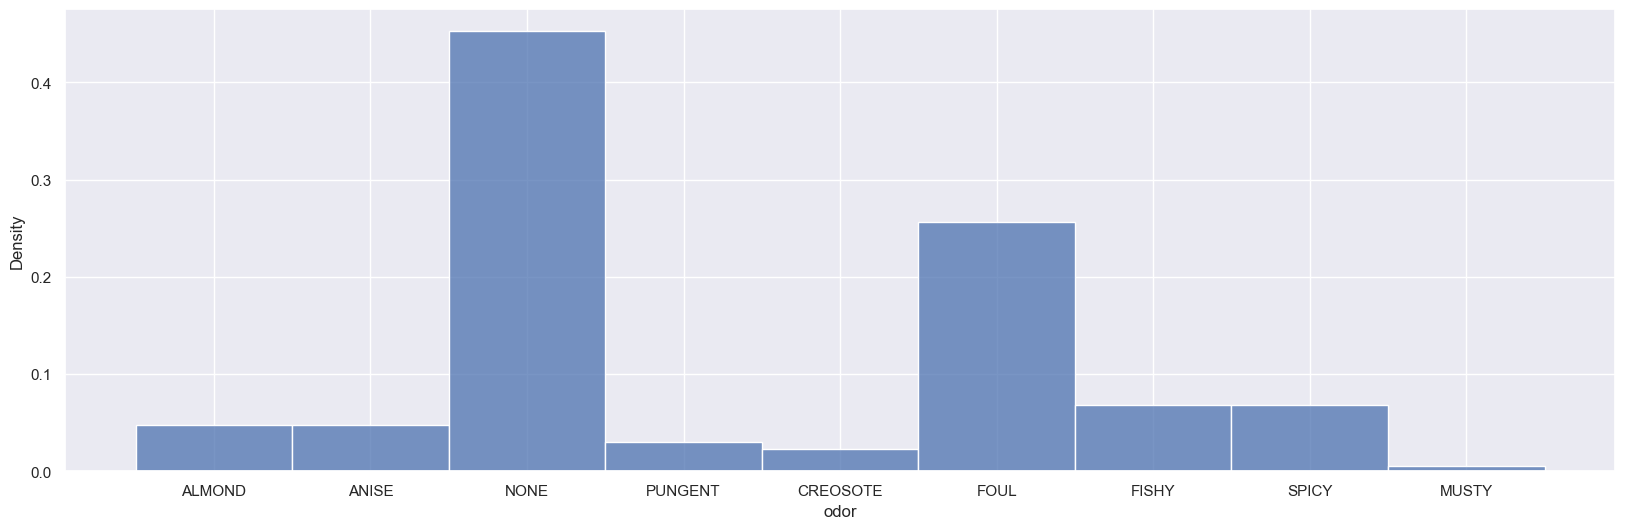

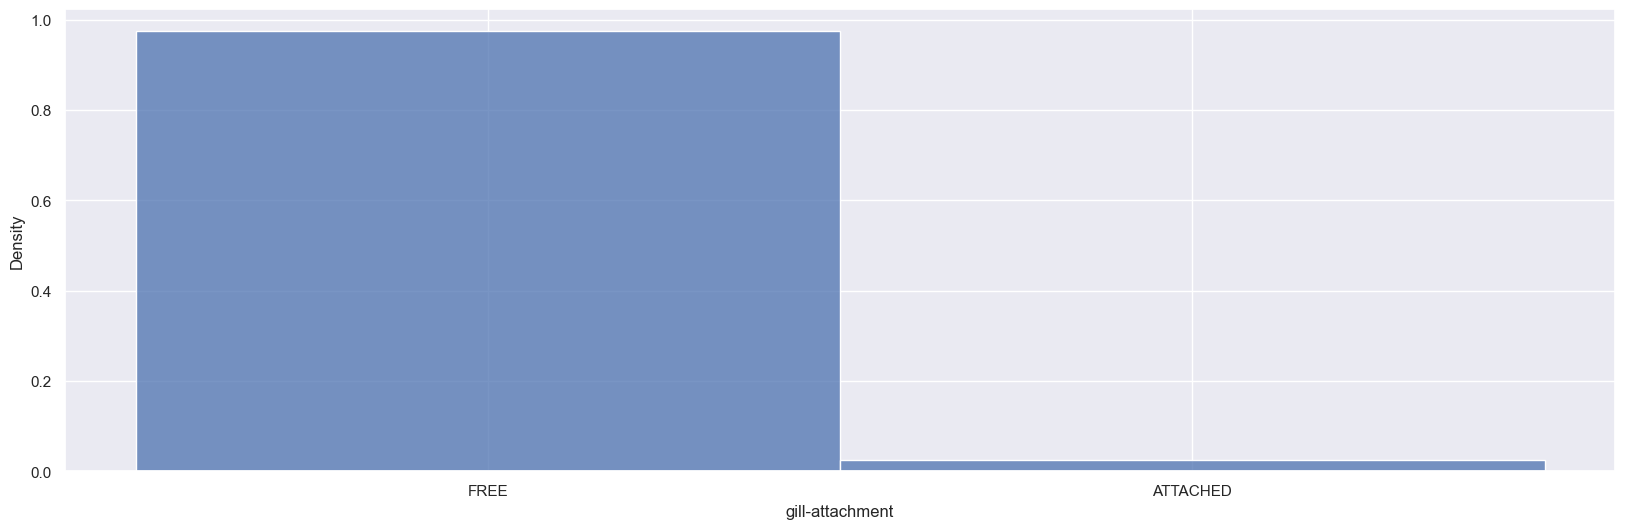

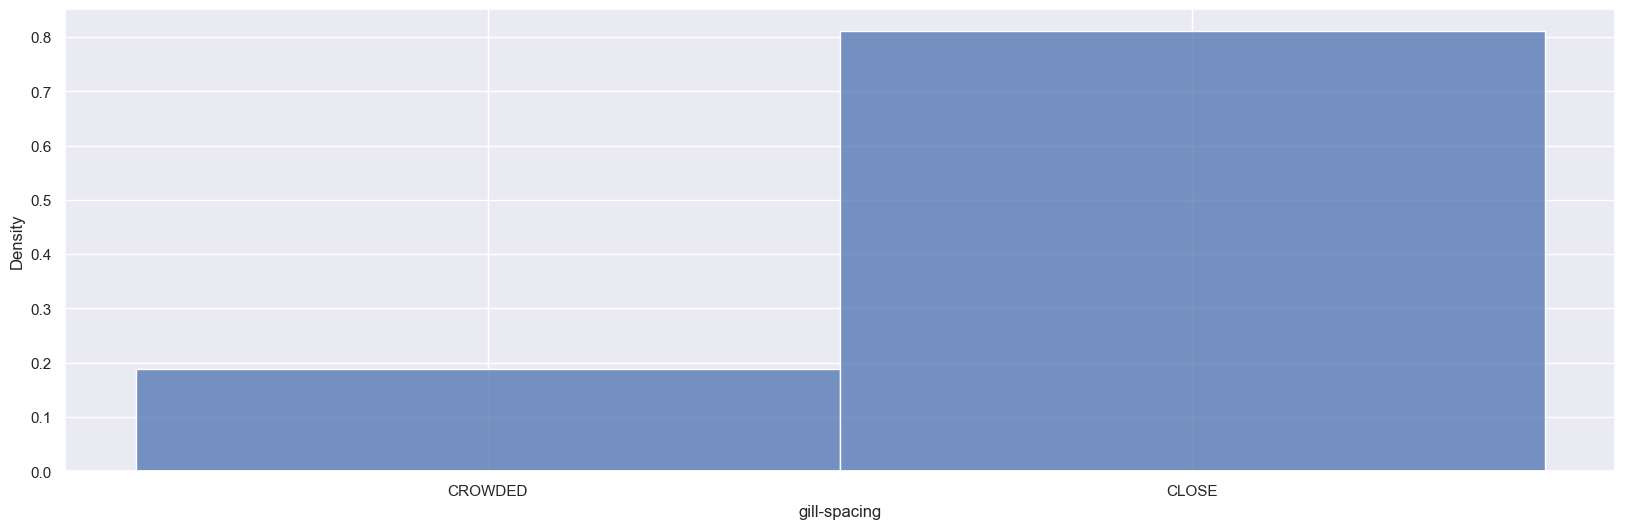

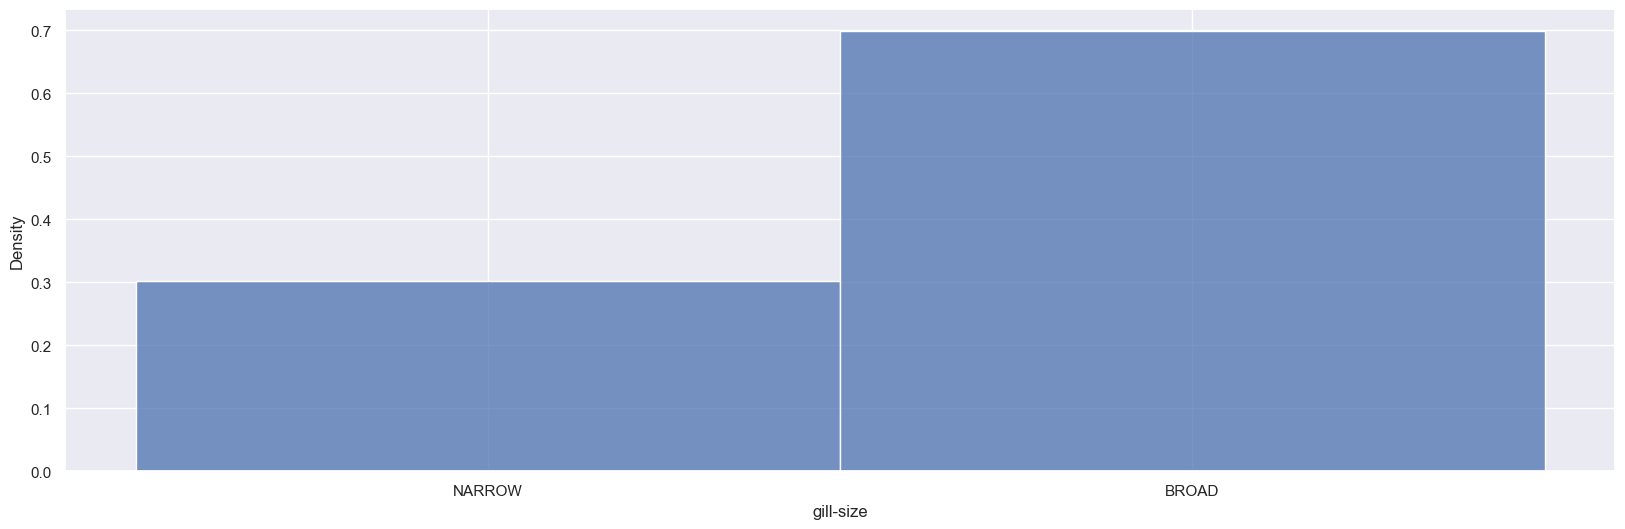

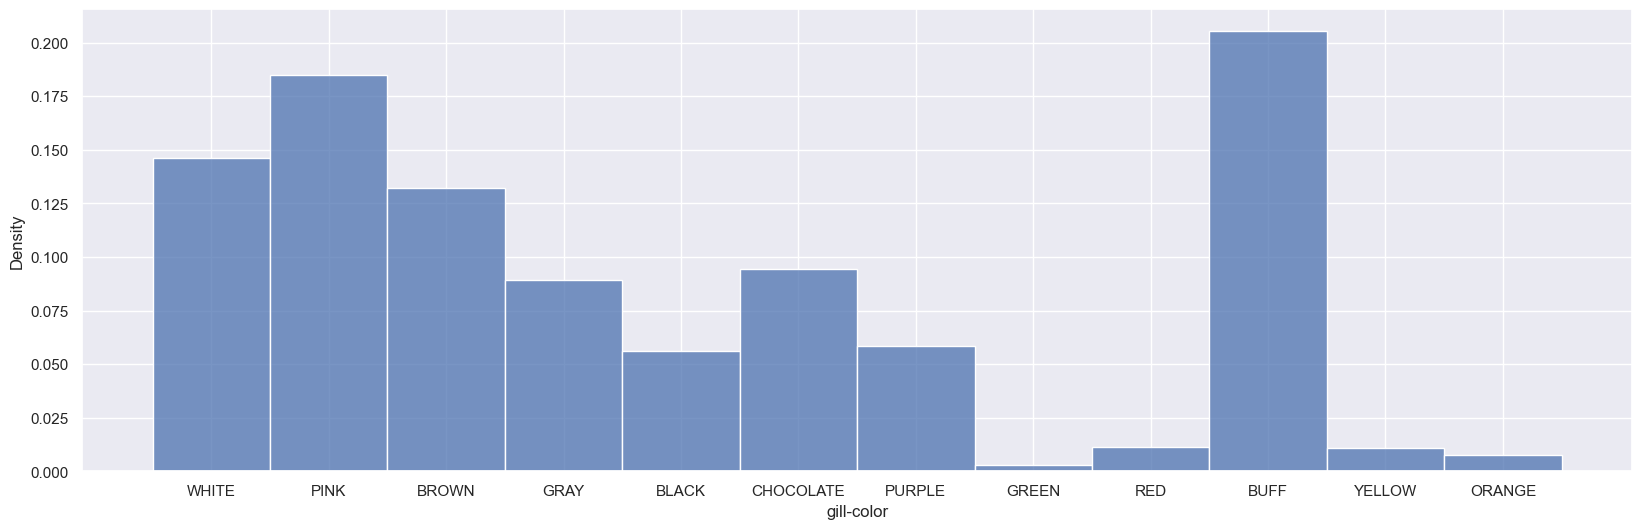

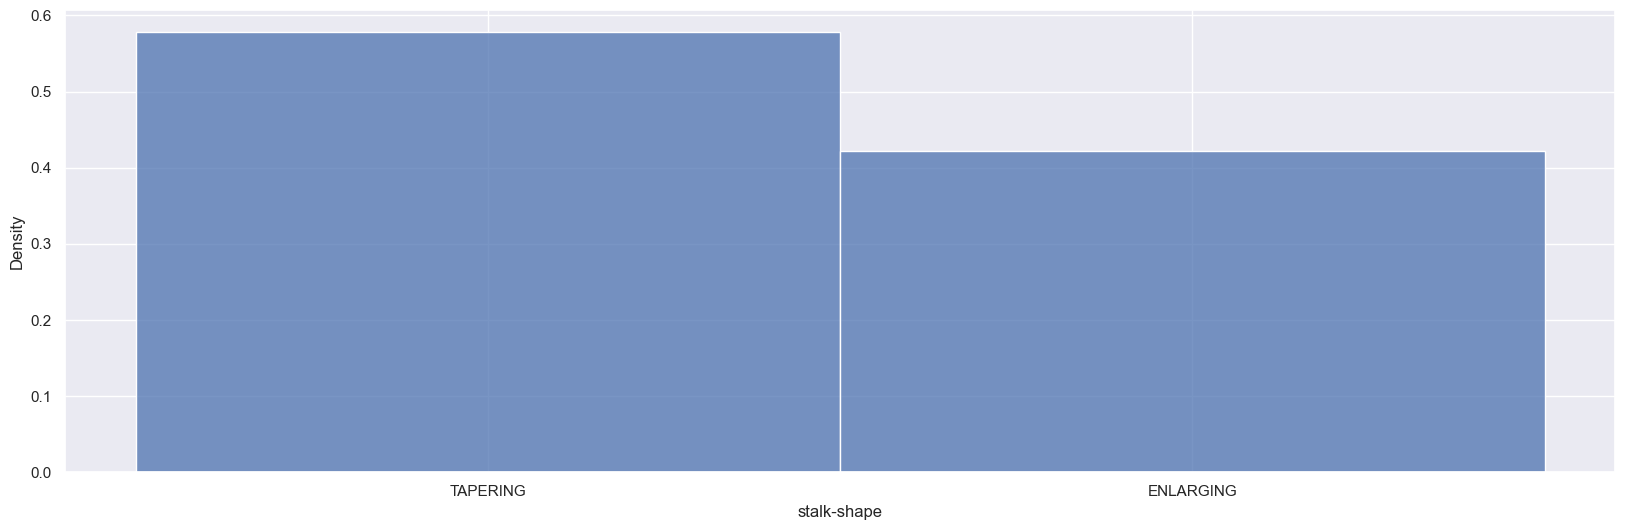

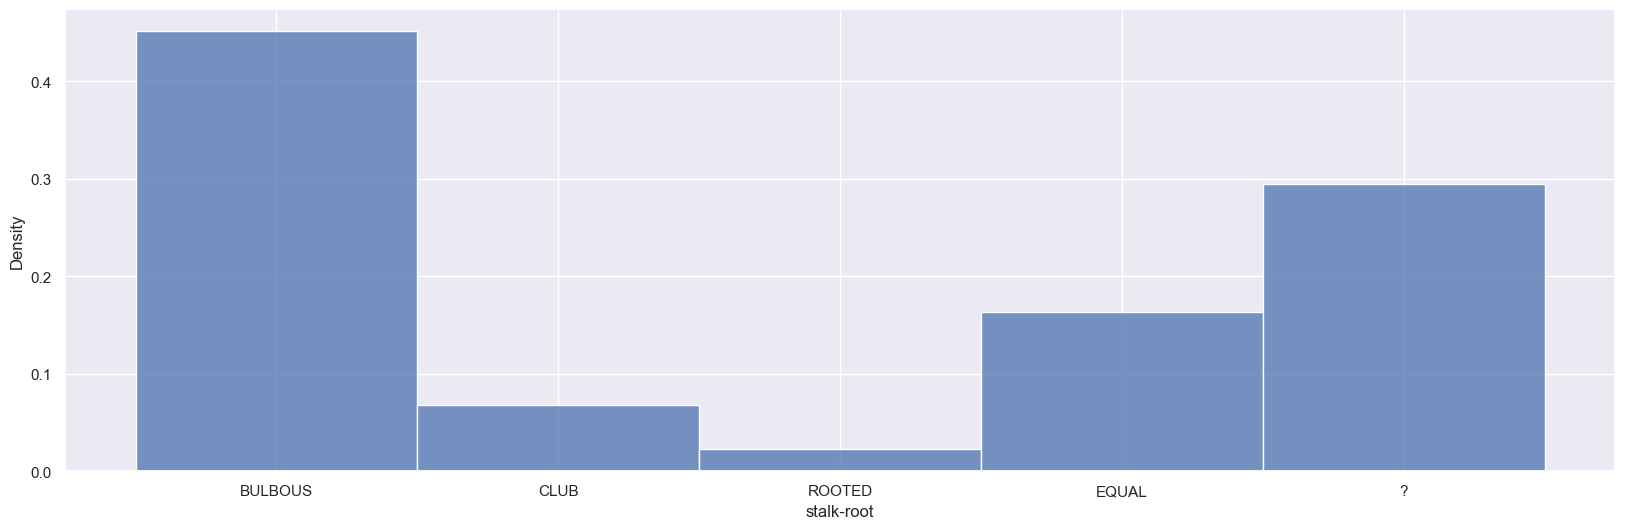

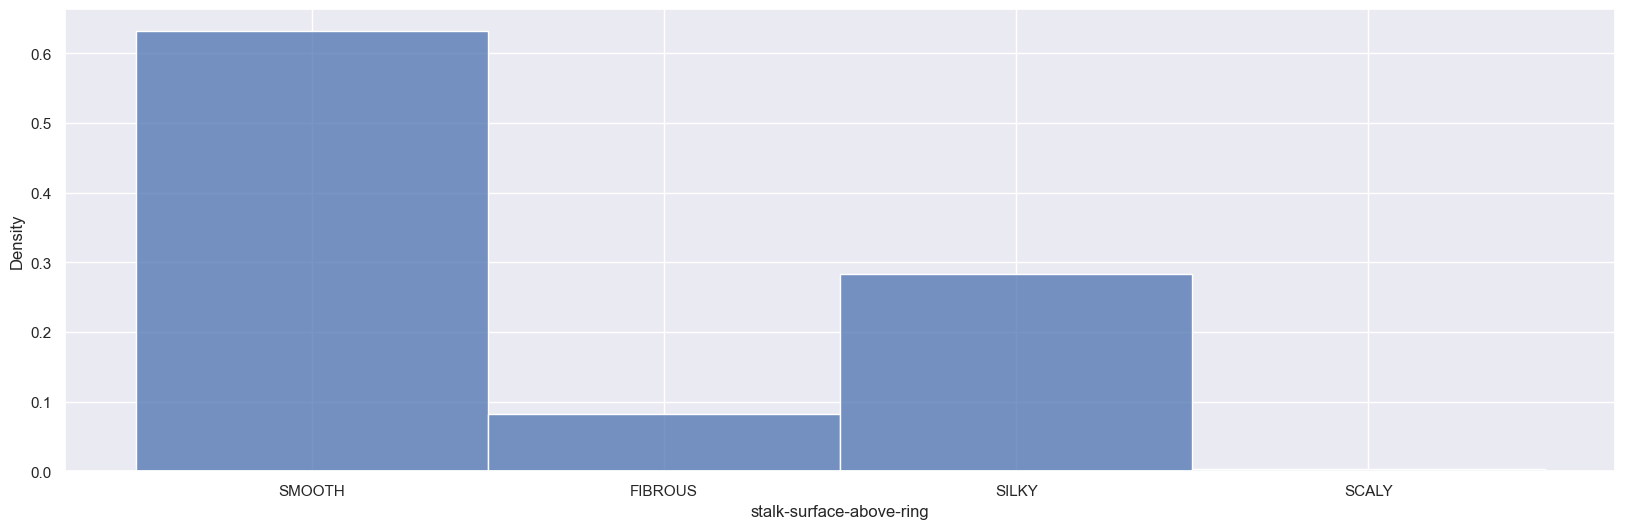

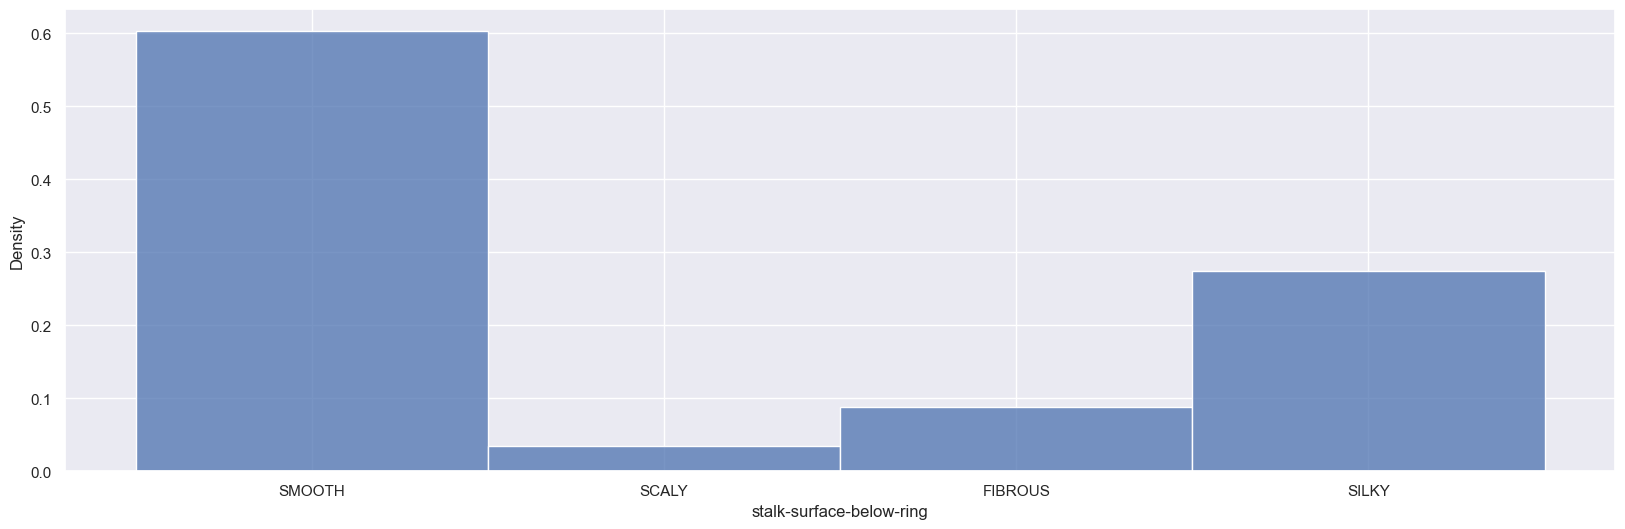

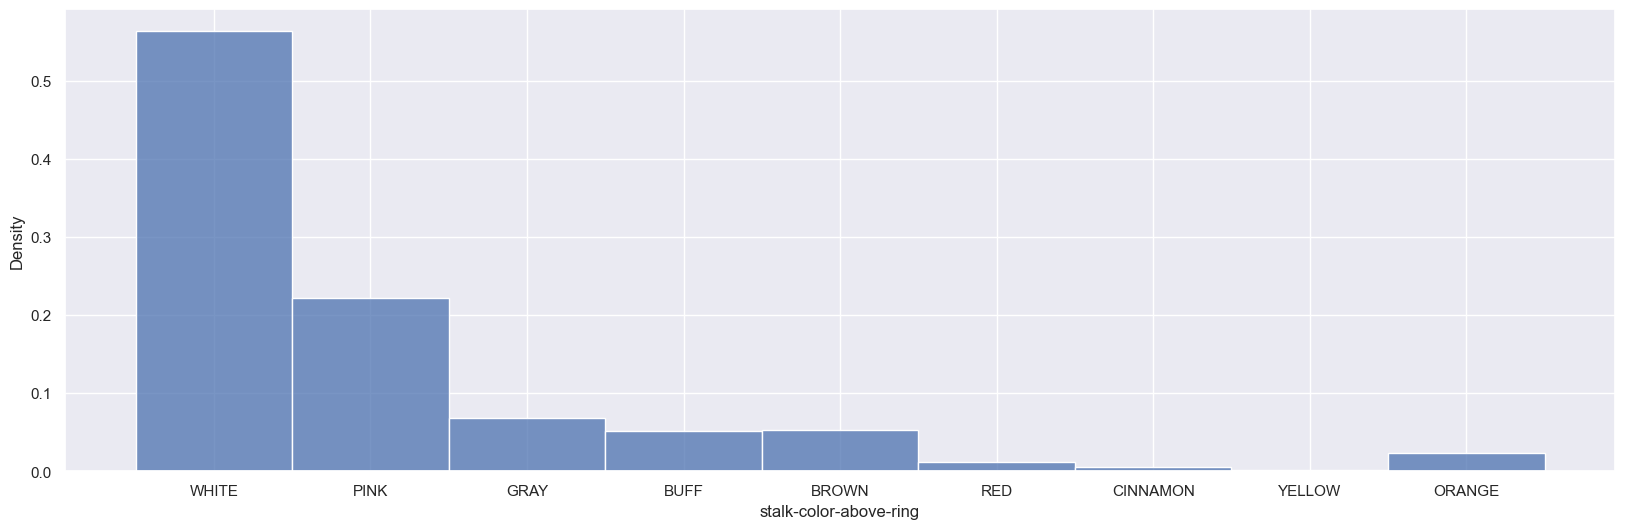

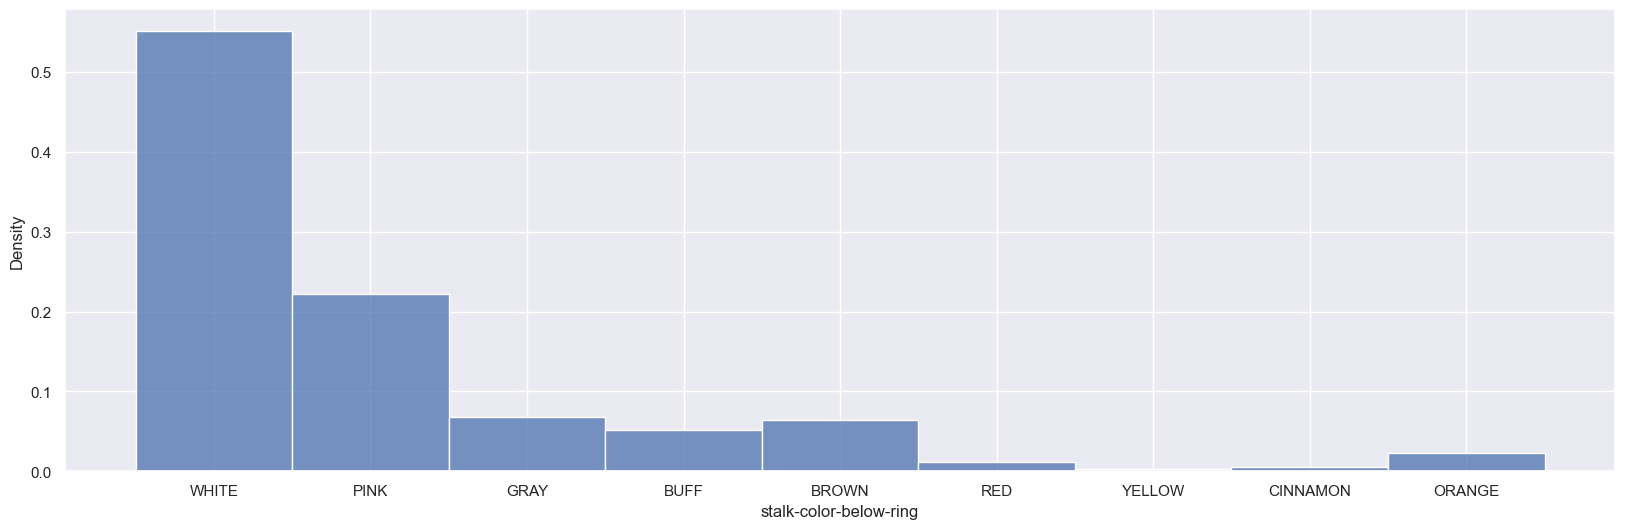

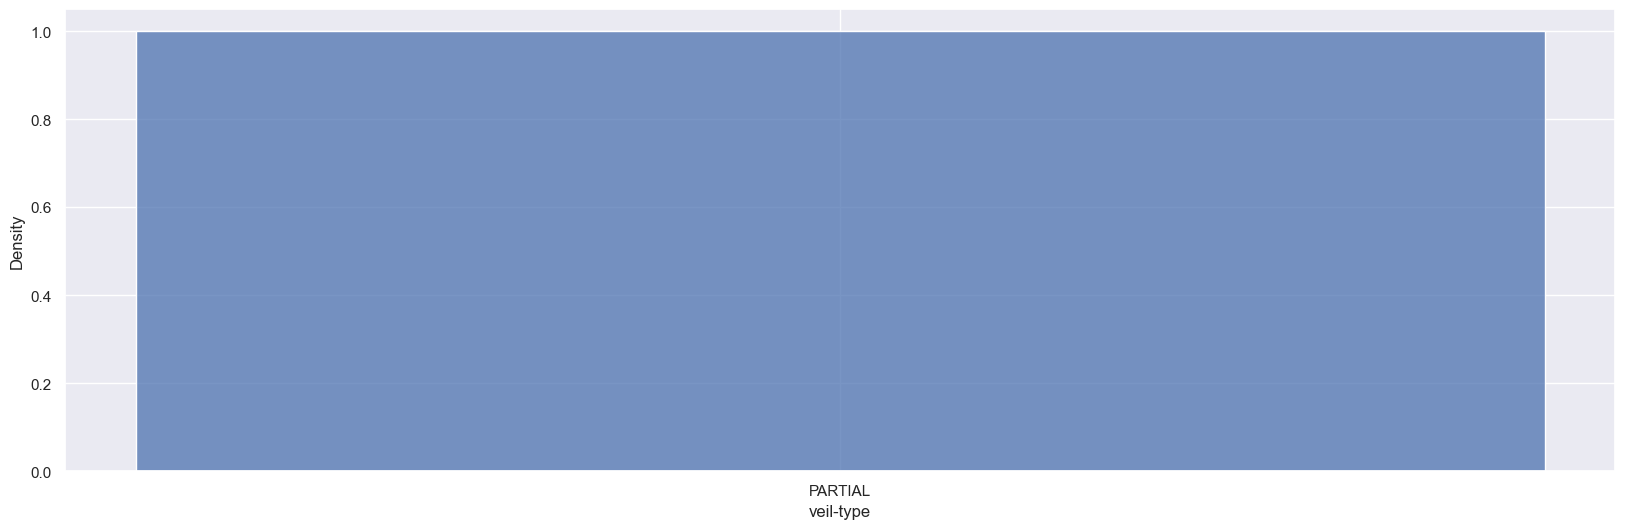

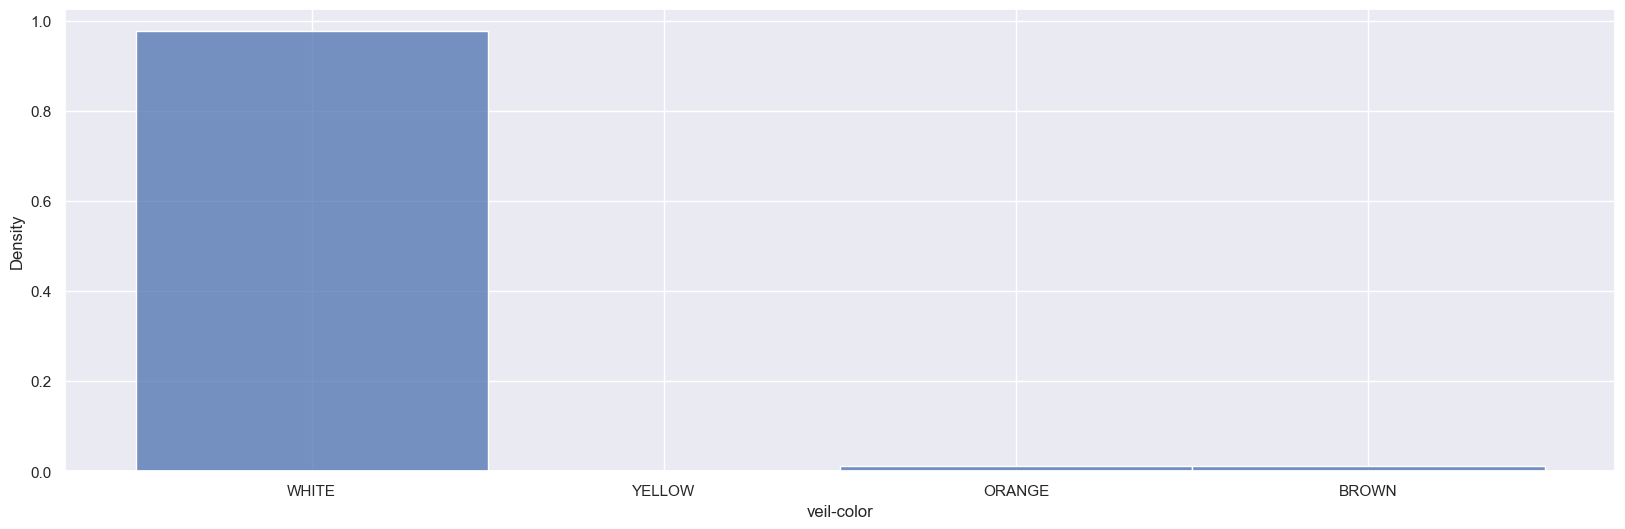

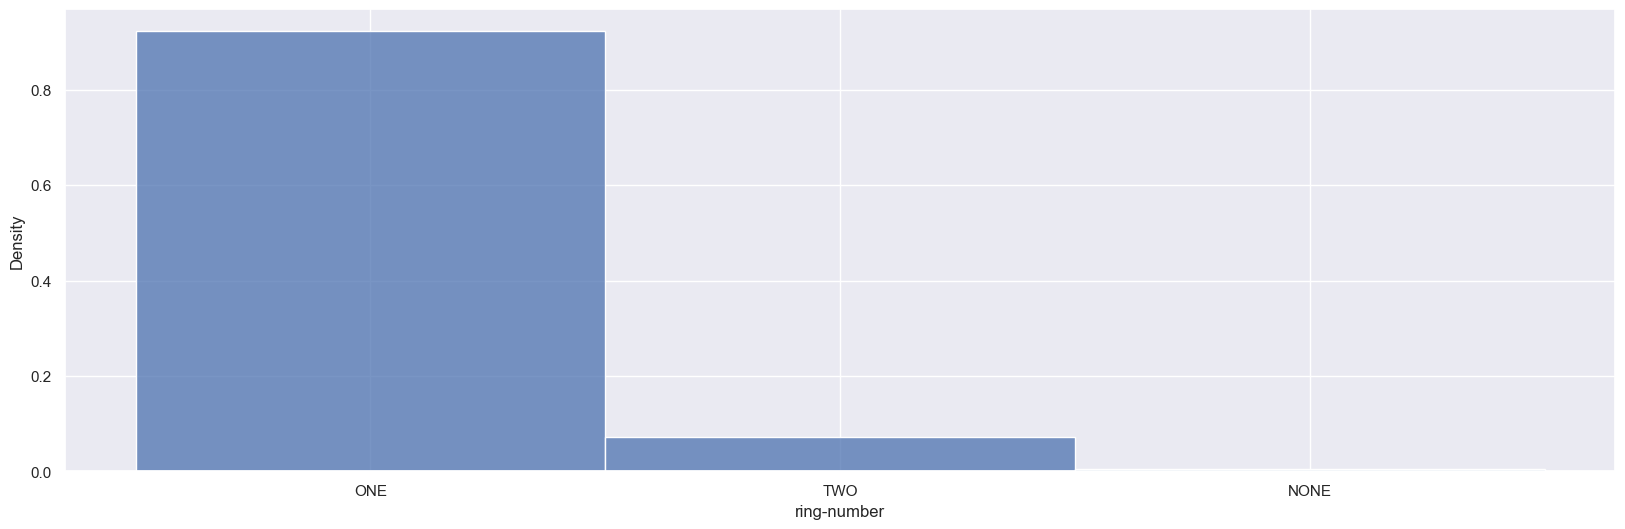

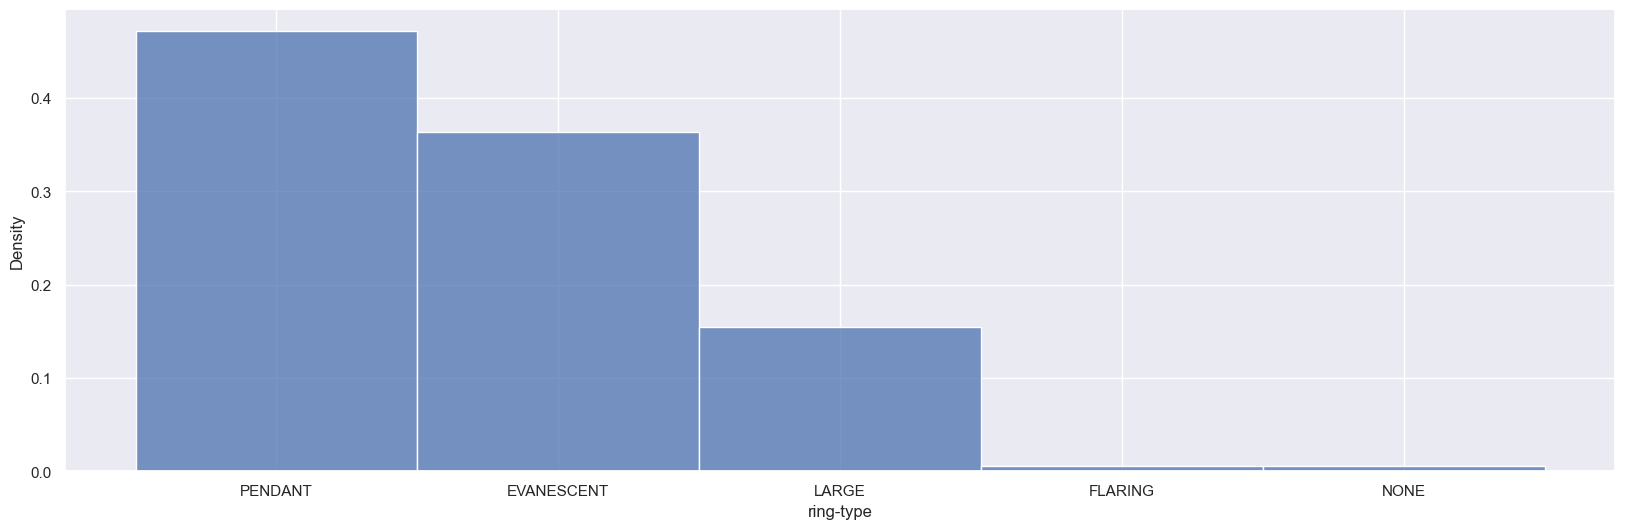

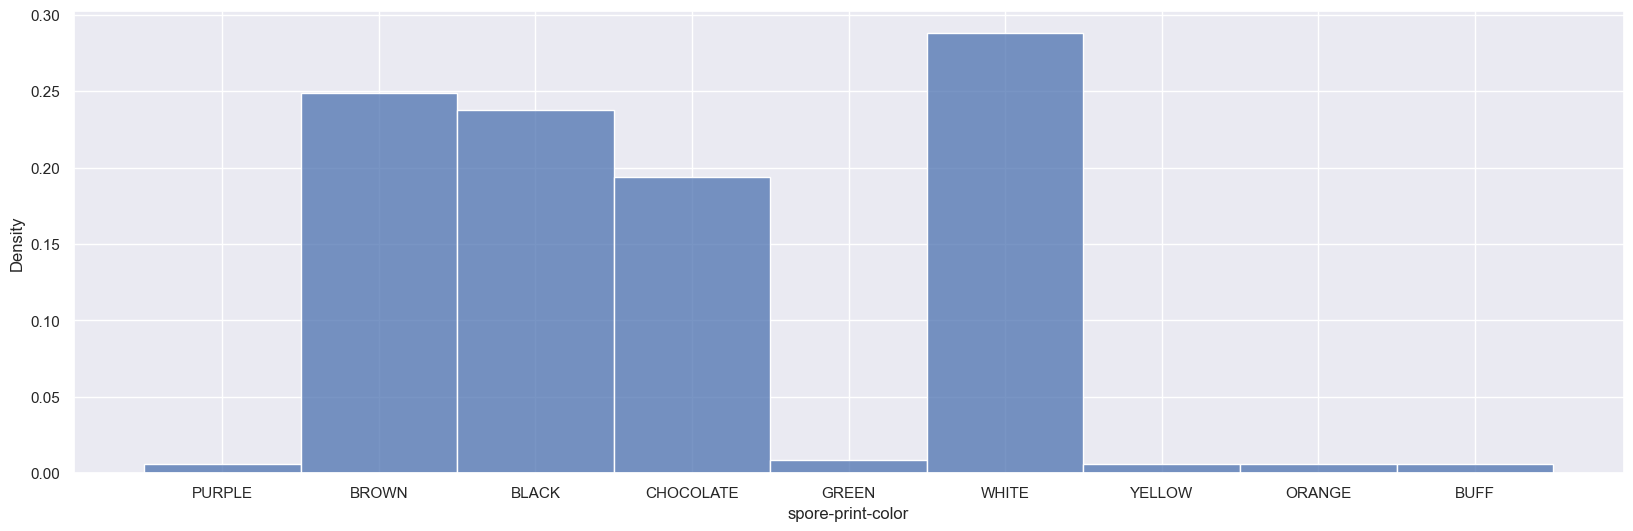

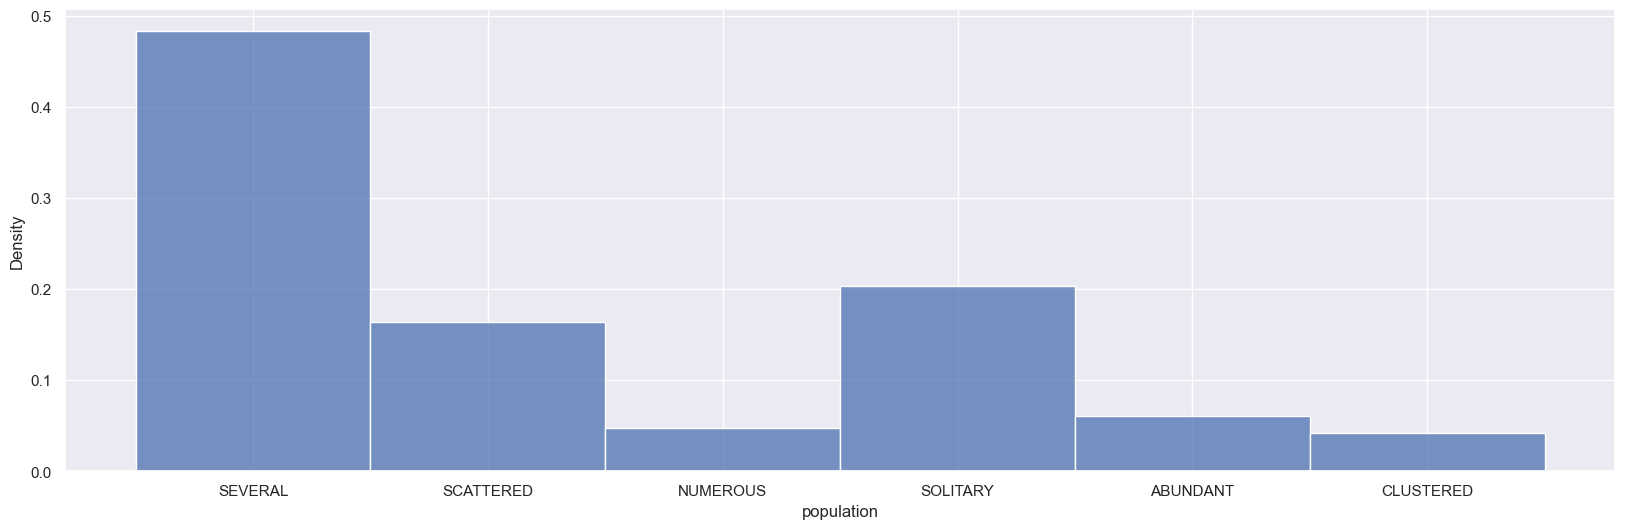

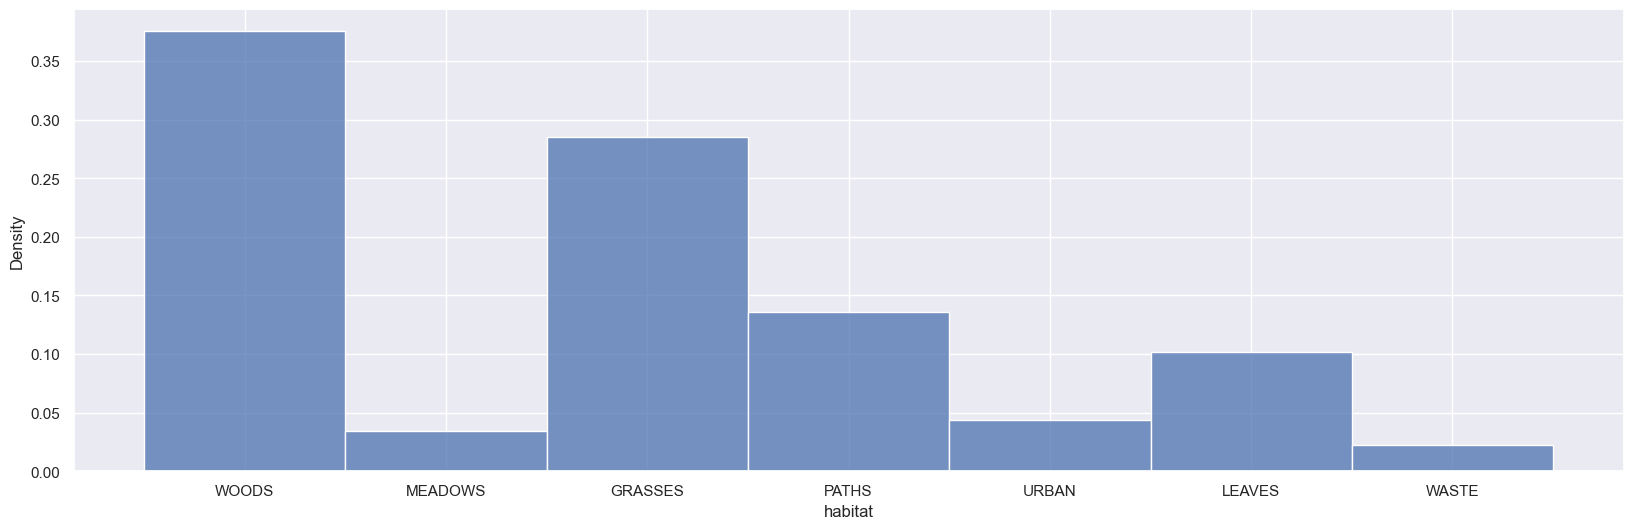

In [41]:
for i in df.columns:
    plt.figure(i)
    sns.histplot(df[i],stat="density")
    plt.show()

Our data is pretty balanced between edible and poisonous so we continue with preprocessing. We convert non numeric data to numeric data with label encoder.

splitiing the class label into edible and poisonous.

In [42]:
df['edible'] = df['class-label'].map({'EDIBLE': 1, 'POISONOUS': 0})
df['poisonous'] = df['class-label'].map({'EDIBLE': 0, 'POISONOUS': 1})

df = df.drop(columns=['class-label'])
df.head()

cap-shape cap-surface cap-color  bruises    odor gill-attachment  \
0    CONVEX      SMOOTH     WHITE  BRUISES  ALMOND            FREE   
1    CONVEX      SMOOTH     WHITE  BRUISES  ALMOND            FREE   
2    CONVEX      SMOOTH     WHITE  BRUISES  ALMOND            FREE   
3    CONVEX      SMOOTH     WHITE  BRUISES  ALMOND            FREE   
4    CONVEX      SMOOTH     WHITE  BRUISES  ALMOND            FREE   

  gill-spacing gill-size gill-color stalk-shape stalk-root  \
0      CROWDED    NARROW      WHITE    TAPERING    BULBOUS   
1      CROWDED    NARROW      WHITE    TAPERING    BULBOUS   
2      CROWDED    NARROW       PINK    TAPERING    BULBOUS   
3      CROWDED    NARROW       PINK    TAPERING    BULBOUS   
4      CROWDED    NARROW      BROWN    TAPERING    BULBOUS   

  stalk-surface-above-ring stalk-surface-below-ring stalk-color-above-ring  \
0                   SMOOTH                   SMOOTH                  WHITE   
1                   SMOOTH                   SMOOTH                  WHITE   
2                   SMOOTH                   SMOOTH                  WHITE   
3                   SMOOTH                   SMOOTH                  WHITE   
4                   SMOOTH                   SMOOTH                  WHITE   

  stalk-color-below-ring veil-type veil-color ring-number ring-type  \
0                  WHITE   PARTIAL      WHITE         ONE   PENDANT   
1                  WHITE   PARTIAL      WHITE         ONE   PENDANT   
2                  WHITE   PARTIAL      WHITE         ONE   PENDANT   
3                  WHITE   PARTIAL      WHITE         ONE   PENDANT   
4                  WHITE   PARTIAL      WHITE         ONE   PENDANT   

  spore-print-color population habitat  edible  poisonous  
0            PURPLE    SEVERAL   WOODS       1          0  
1             BROWN    SEVERAL   WOODS       1          0  
2            PURPLE    SEVERAL   WOODS       1          0  
3             BROWN    SEVERAL   WOODS       1          0  
4            PURPLE    SEVERAL   WOODS       1          0

In [43]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for col in df.columns:
    df[col] = le.fit_transform(df[col])

df.head()

cap-shape  cap-surface  cap-color  bruises  odor  gill-attachment  \
0          2            3          8        0     0                1   
1          2            3          8        0     0                1   
2          2            3          8        0     0                1   
3          2            3          8        0     0                1   
4          2            3          8        0     0                1   

   gill-spacing  gill-size  gill-color  stalk-shape  stalk-root  \
0             1          1          10            1           1   
1             1          1          10            1           1   
2             1          1           7            1           1   
3             1          1           7            1           1   
4             1          1           1            1           1   

   stalk-surface-above-ring  stalk-surface-below-ring  stalk-color-above-ring  \
0                         3                         3                       7   
1                         3                         3                       7   
2                         3                         3                       7   
3                         3                         3                       7   
4                         3                         3                       7   

   stalk-color-below-ring  veil-type  veil-color  ring-number  ring-type  \
0                       7          0           2            1          4   
1                       7          0           2            1          4   
2                       7          0           2            1          4   
3                       7          0           2            1          4   
4                       7          0           2            1          4   

   spore-print-color  population  habitat  edible  poisonous  
0                  6           4        6       1          0  
1                  1           4        6       1          0  
2                  6           4        6       1          0  
3                  1           4        6       1          0  
4                  6           4        6       1          0

Checking our data for distinct values.

In [44]:
for col in df.columns:
    print(f'{col}: {str(df[col].nunique())}')

cap-shape: 6
cap-surface: 4
cap-color: 10
bruises: 2
odor: 9
gill-attachment: 2
gill-spacing: 2
gill-size: 2
gill-color: 12
stalk-shape: 2
stalk-root: 5
stalk-surface-above-ring: 4
stalk-surface-below-ring: 4
stalk-color-above-ring: 9
stalk-color-below-ring: 9
veil-type: 1
veil-color: 4
ring-number: 3
ring-type: 5
spore-print-color: 9
population: 6
habitat: 7
edible: 2
poisonous: 2


A function to perform descriptive statistics with some additional metrics not found in the info() function.

In [45]:
def descriptive_stats(df):
    #adding additional statsical parameters to check our data
    C = len(df.columns)
    L = len(df.index)
    CN = df.count()
    NP = ((L-CN)/L)*100
    MN = df.min()
    Q1 = df.quantile(q=0.25)
    MA=df.mean() 
    ME=df.median() 
    Q3=df.quantile(q=0.75) 
    MX=df.max() 
    ST=df.std() 
    P=df.nunique() 
    IQ=Q3-Q1 

    frame = pd.concat([CN, NP, MN, Q1, MA, ME, Q3, MX, ST, P, IQ], axis=1, join="inner")
    frame=frame.T
    f=pd.DataFrame(frame)
    f.index=['Количество', 'Процент пропусков', 'Минимум', 'Первый квартиль','Среднее', 'Медиана', 'Третий квартиль', 'Максимум','Стандартное отклонение', 'Мощность', 'Интерквартильный размах']
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    f1=f.style.apply(lambda x: ["background-color:tomato" if i==1 else "" for i in x], axis=1, subset=(["Мощность"], slice(None))).apply(lambda x: ["background-color:tomato" if i>=60 else "" for i in x], axis=1, subset=(["Процент пропусков"], slice(None))).apply(lambda x: ["background-color:steelblue" if (i<30 and i>0) else "" for i in x], axis=1, subset=(["Процент пропусков"], slice(None))).apply(lambda x: ["background-color:limegreen" if i==0 else "" for i in x], axis=1, subset=(["Процент пропусков"], slice(None)))
    return f,f1

f,f1 = descriptive_stats(df)
f1

Veil-type has a power of 1 so we drop it.

In [46]:
df = df.drop(columns=['veil-type'])
df.head()

cap-shape  cap-surface  cap-color  bruises  odor  gill-attachment  \
0          2            3          8        0     0                1   
1          2            3          8        0     0                1   
2          2            3          8        0     0                1   
3          2            3          8        0     0                1   
4          2            3          8        0     0                1   

   gill-spacing  gill-size  gill-color  stalk-shape  stalk-root  \
0             1          1          10            1           1   
1             1          1          10            1           1   
2             1          1           7            1           1   
3             1          1           7            1           1   
4             1          1           1            1           1   

   stalk-surface-above-ring  stalk-surface-below-ring  stalk-color-above-ring  \
0                         3                         3                       7   
1                         3                         3                       7   
2                         3                         3                       7   
3                         3                         3                       7   
4                         3                         3                       7   

   stalk-color-below-ring  veil-color  ring-number  ring-type  \
0                       7           2            1          4   
1                       7           2            1          4   
2                       7           2            1          4   
3                       7           2            1          4   
4                       7           2            1          4   

   spore-print-color  population  habitat  edible  poisonous  
0                  6           4        6       1          0  
1                  1           4        6       1          0  
2                  6           4        6       1          0  
3                  1           4        6       1          0  
4                  6           4        6       1          0

In [47]:
f, f1 = descriptive_stats(df)
f1

Let's create a hetmap for correlation between features.

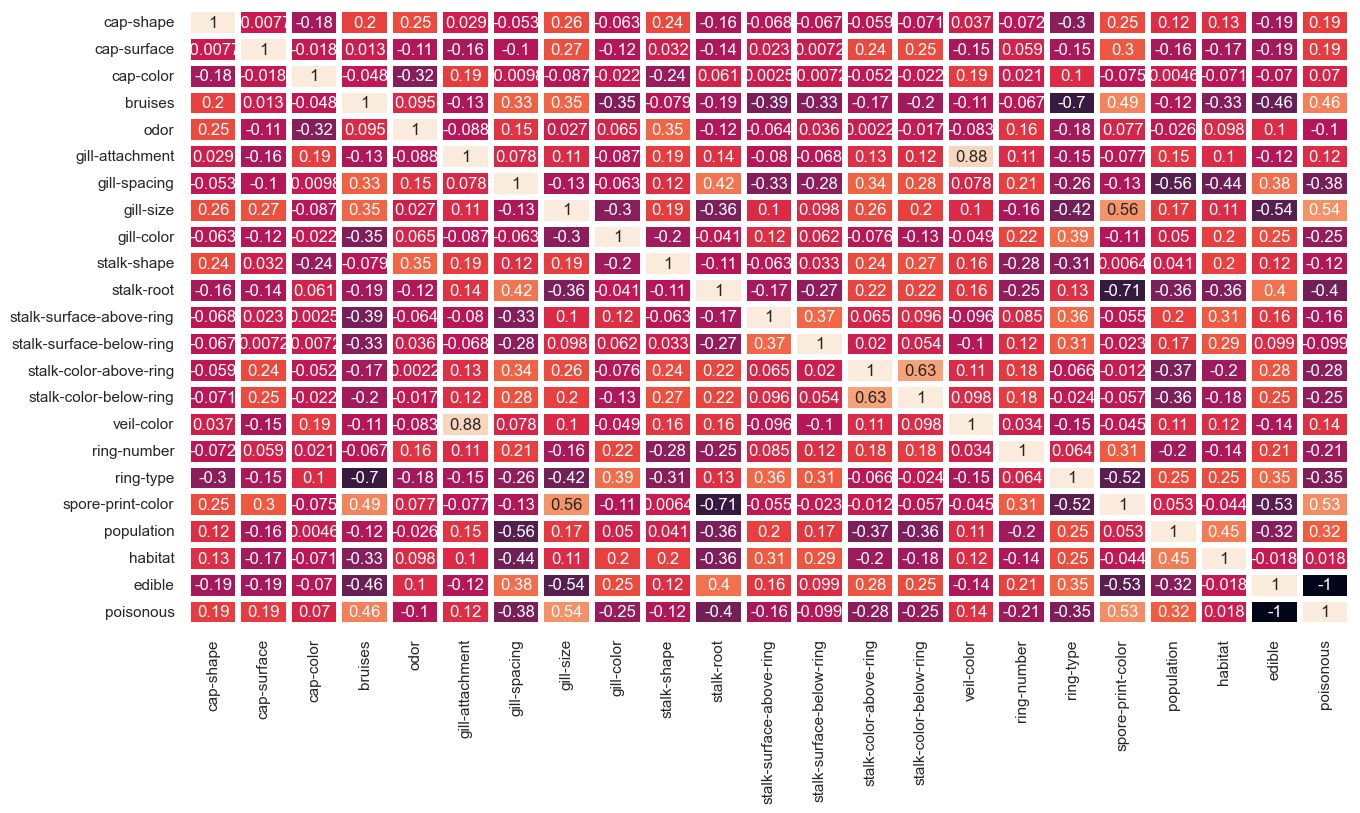

In [48]:
def make_heat_map(df):
    sns.set(rc={'figure.figsize': (15,8),})
    sns.heatmap(df.corr(), annot=True, linewidths=3, cbar=False)

make_heat_map(df)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8416 entries, 0 to 8415
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   cap-shape                 8416 non-null   int32
 1   cap-surface               8416 non-null   int32
 2   cap-color                 8416 non-null   int32
 3   bruises                   8416 non-null   int32
 4   odor                      8416 non-null   int32
 5   gill-attachment           8416 non-null   int32
 6   gill-spacing              8416 non-null   int32
 7   gill-size                 8416 non-null   int32
 8   gill-color                8416 non-null   int32
 9   stalk-shape               8416 non-null   int32
 10  stalk-root                8416 non-null   int32
 11  stalk-surface-above-ring  8416 non-null   int32
 12  stalk-surface-below-ring  8416 non-null   int32
 13  stalk-color-above-ring    8416 non-null   int32
 14  stalk-color-below-ring    8416 non-null 

Let's plot the feature importances.

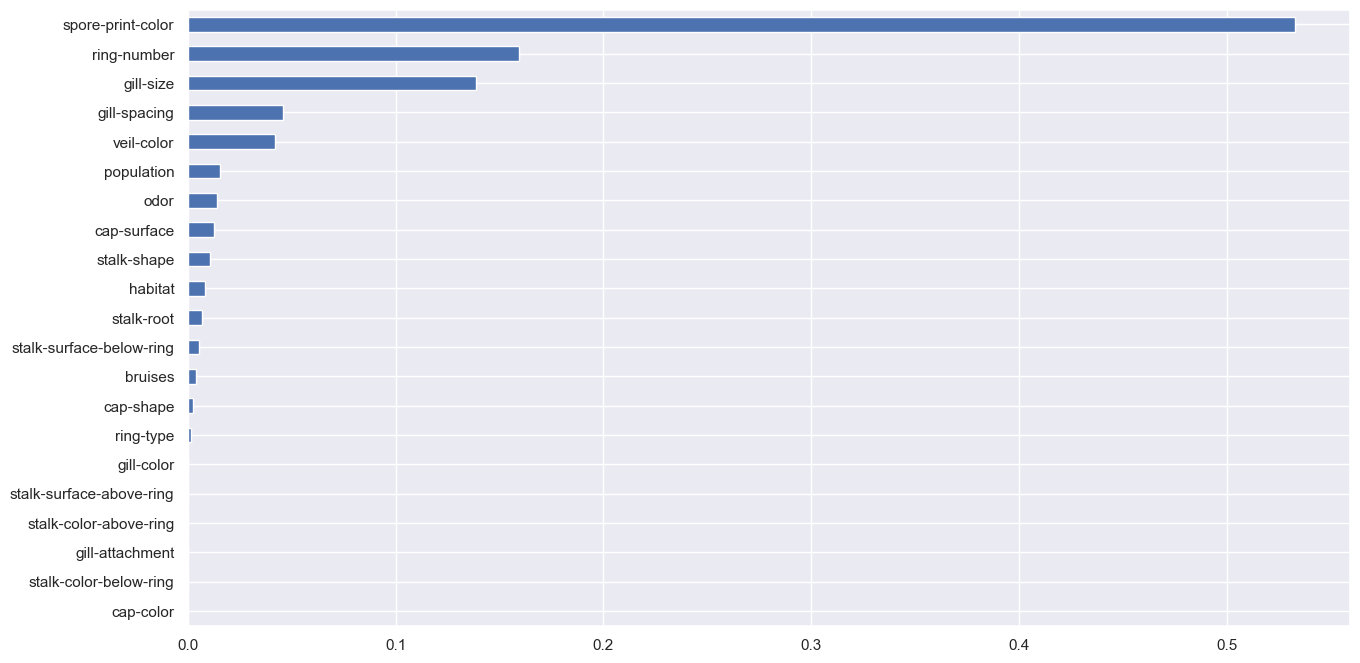

In [50]:
from sklearn.ensemble import RandomForestRegressor
def feature_importance(X, Y):

    regr = RandomForestRegressor(max_depth=20, random_state=42)
    regr.fit(X, Y)
    feat_importances = pd.Series(regr.feature_importances_, index=X.columns).sort_values(ascending=True)
    feat_importances.plot(kind='barh')

X=df.drop(columns=['edible','poisonous'],axis=1)
Y=df.iloc[:,21:23]

feature_importance(X, Y)

Let's perform PCA to check for the number of principal components.

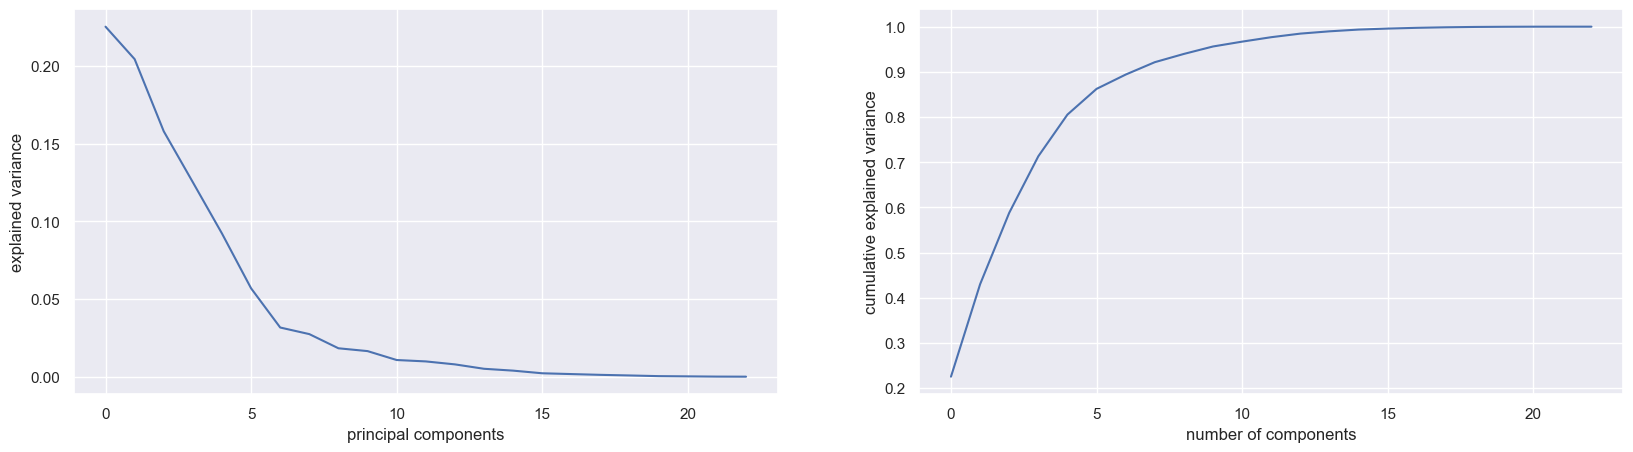

In [51]:
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=123) #instant
pca.fit(df)
fig = plt.figure(figsize = (20,5))
ax = plt.subplot(121)
plt.plot(pca.explained_variance_ratio_) 
plt.xlabel('principal components')
plt.ylabel('explained variance')
ax2 = plt.subplot (122)
plt.plot(np.cumsum(pca.explained_variance_ratio_)) 
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

As we can see in the graph more than 90 percent of variance can be explained by about 15 components. In the future the unnecessary components can be removed to reduce dataset size and decrease training time.

Splitting the dataset into training and test sets. in our case it will be 70-30 split.

In [52]:
# df_encoded = pd.concat([df.iloc[:,0], pd.get_dummies(df.iloc[:, 1:23])], axis=1)
X=df.drop(columns=['edible','poisonous'],axis=1)
y=df.iloc[:,21:23]

X_train,X_test, y_train, y_test = train_test_split(X, y , test_size=0.3, random_state=42)
print(f'Size of training set: {X_train.shape}')
print(f'Size of test set: {X_test.shape}')
print(f'The size of the target variable for training sample: {y_train.shape}')
print(f'The size of the target variable for test sample: {y_test.shape}')

Size of training set: (5891, 21)
Size of test set: (2525, 21)
The size of the target variable for training sample: (5891, 2)
The size of the target variable for test sample: (2525, 2)


Let's create the necessary functions for creating a confusion matrix, accuracy, precision, recall and F1 score. We will also create a function to plot the ROC curve.

In [53]:
def confusion_matrix(y, y_pred):
    TP = np.sum((y == 1) & (y_pred == 1))
    TN = np.sum((y == 0) & (y_pred == 0))
    FP = np.sum((y == 0) & (y_pred == 1))
    FN = np.sum((y == 1) & (y_pred == 0))
    return TP,TN,FP,FN

def accuracy(TP,TN,FP,FN):
    return (TP + TN)/(TP + TN + FP + FN)

def precision(TP,FP):
    return TP/(TP + FP) if (TP + FP) != 0 else 0

def recall(TP, FN):
    return TP/ (TP + FN) if (TP + FN) != 0 else 0

def f1_score(percision, recall):
    return 2 * (percision * recall) / (percision + recall) if percision + recall != 0 else 0

def roc_curve_manual(y_true, y_prob):
    thresholds = np.linspace(0, 1, 101)
    tpr_list = []
    fpr_list = []
    
    for thresh in thresholds:
        y_pred = (y_prob >= thresh).astype(int)
        TP, TN, FP, FN = confusion_matrix(y_true, y_pred)
        tpr = recall(TP, FN)
        fpr = FP / (FP + TN) if FP + TN != 0 else 0
        tpr_list.append(tpr)
        fpr_list.append(fpr)

    return np.array(fpr_list), np.array(tpr_list), thresholds

def auc_manual(fpr, tpr):
    sorted_indices = np.argsort(fpr)
    fpr_sorted = fpr[sorted_indices]
    tpr_sorted = tpr[sorted_indices]
    auc = np.trapz(tpr_sorted, fpr_sorted)
    return auc

Converting the sets into float32 datatype to avoid any problems while working with numpy.

In [54]:
# X_train = np.array(X_train, dtype=np.float32)
# y_train = np.array(y_train, dtype=np.float32)
# X_test = np.array(X_test, dtype=np.float32)
# y_test = np.array(y_test, dtype=np.float32)
# y_test

Training the model and plotting all the necessary graphs.

Epoch 0, Loss: 0.7239318539041046
Epoch 100, Loss: 0.30544492357578995
Epoch 200, Loss: 0.2546686701875208
Epoch 300, Loss: 0.18435493381168122
Epoch 400, Loss: 0.09001177557627042
Epoch 500, Loss: 0.06445567078089842
Epoch 600, Loss: 0.0501528678191742
Epoch 700, Loss: 0.03711748305830266
R^2 = 0.9905509053944266
Accuracy: 0.9984
Precision: 0.9984
Recall: 0.9984
F1 Score: 0.9984


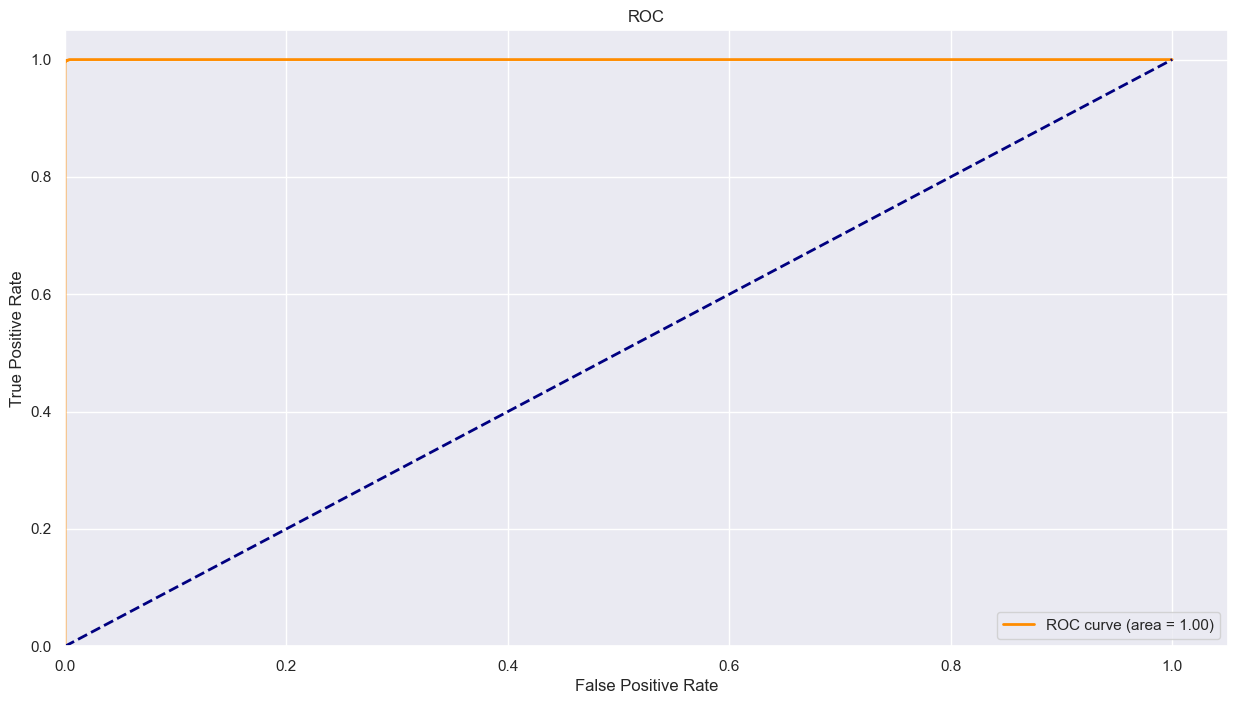

In [55]:
#creating our architecture. It will have 2 hidden layers and output layer with two neurons.
net_arch = (21, 11, 5, 2)
mlp = MLP(net_arch,learning_rate=0.0001)
y_train = np.array(y_train).reshape(-1, 2)
y_test = np.array(y_test).reshape(-1, 2)
epochs = 800
#we train the model for 800 epochs.
mlp.train(X_train, y_train, epochs=epochs)

# Prediction and assessment
y_pred_prob = mlp._feedforward(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

#R^2
print(f'R^2 = {R_square(y_pred_prob,y_test)}')

# Calculation of error matrix elements
TP, TN, FP, FN = confusion_matrix(y_test, y_pred)

# Calculating metrics
accuracy_value = accuracy(TP, TN, FP, FN)
precision_value = precision(TP, FP)
recall_value = recall(TP, FN)
f1_value = f1_score(precision_value, recall_value)

print(f"Accuracy: {accuracy_value:.4f}")
print(f"Precision: {precision_value:.4f}")
print(f"Recall: {recall_value:.4f}")
print(f"F1 Score: {f1_value:.4f}")

# Building ROC-Curve manually
fpr, tpr, thresholds = roc_curve_manual(y_test, y_pred_prob)
roc_auc = auc_manual(fpr, tpr)

#plotting the curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()


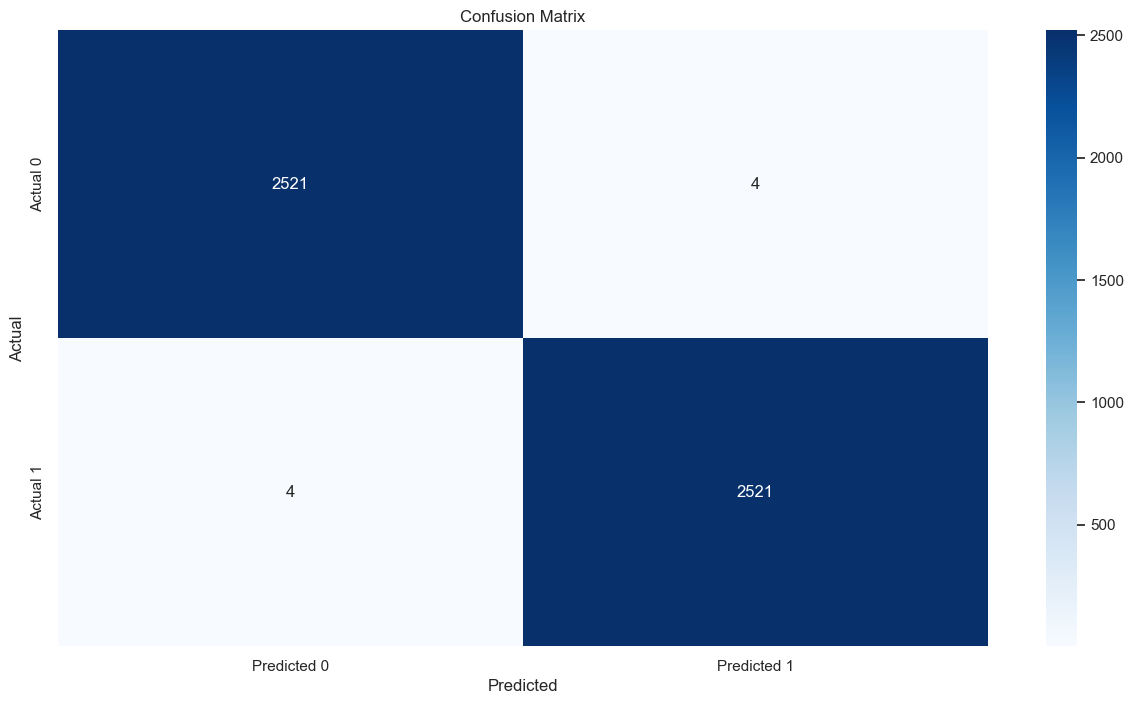

In [56]:
cm = np.array([[TN, FP],
               [FN, TP]])
# Visualization of the confusion matrix using matplotlib
plt.title('Confusion Matrix')
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True, linewidths=0)

# Set the axes tags
ax.set_xticklabels(['Predicted 0', 'Predicted 1'])
ax.set_yticklabels(['Actual 0', 'Actual 1'])


# Labels
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

Let's see the prediction on the test dataset.

In [57]:
#predicting on our test set
data = mlp._feedforward(X_test)
c = np.argmax(data, axis=1)
label_mapping = {0: "edible", 1: "poisonous"}
class_labels_str = np.array([label_mapping[label] for label in c])

actual = np.argmax(y_test, axis=1)
label_mapping = {0: "edible", 1: "poisonous"}
actual_str = np.array([label_mapping[label] for label in actual])


dfres = pd.DataFrame(data = X_test)
dfres.insert(0, 'prediction', class_labels_str, True)
dfres.insert(1,'actually_value',actual_str, True)
dfres

prediction actually_value  cap-shape  cap-surface  cap-color  bruises  \
7223  poisonous      poisonous          3            2          0        1   
4591  poisonous      poisonous          2            2          9        1   
2522     edible         edible          2            0          0        0   
6223  poisonous      poisonous          2            3          7        1   
2436     edible         edible          2            0          7        0   
4264  poisonous      poisonous          2            0          9        1   
7897     edible         edible          0            3          8        1   
2698     edible         edible          2            2          3        0   
2391     edible         edible          2            0          7        0   
6827  poisonous      poisonous          3            3          0        1   
263      edible         edible          0            2          8        0   
4397  poisonous      poisonous          2            0          9        1   
1656     edible         edible          2            0          0        1   
33       edible         edible          2            0          8        0   
828      edible         edible          2            0          0        1   
5457  poisonous      poisonous          2            3          8        0   
6705  poisonous      poisonous          3            3          7        1   
4778  poisonous      poisonous          3            0          3        1   
7803  poisonous      poisonous          4            2          0        1   
1046  poisonous      poisonous          3            3          8        0   
5686  poisonous      poisonous          3            3          1        0   
586      edible         edible          2            2          9        0   
4122  poisonous      poisonous          2            0          3        1   
2446     edible         edible          2            0          7        0   
5151  poisonous      poisonous          3            2          3        1   
1281     edible         edible          2            3          3        1   
5396     edible         edible          2            2          8        1   
5857     edible         edible          4            0          0        1   
5018  poisonous      poisonous          3            0          9        1   
3653     edible         edible          3            2          7        0   
5758     edible      poisonous          0            2          1        0   
5395     edible         edible          2            2          8        1   
8063     edible         edible          2            0          3        1   
4454  poisonous      poisonous          2            2          3        1   
1320     edible         edible          2            3          3        1   
429      edible         edible          2            3          9        0   
3910  poisonous      poisonous          2            3          8        1   
6719  poisonous      poisonous          3            3          7        1   
2860     edible         edible          2            2          7        0   
5547  poisonous      poisonous          2            3          1        0   
7697  poisonous      poisonous          4            2          0        1   
1844     edible         edible          3            3          3        1   
5920     edible         edible          2            2          7        0   
1323     edible         edible          2            3          3        1   
5007  poisonous      poisonous          3            0          9        1   
3816     edible         edible          3            2          0        0   
5160  poisonous      poisonous          3            2          3        1   
6812  poisonous      poisonous          3            3          7        1   
221      edible         edible          0            3          9        0   
4148  poisonous      poisonous          2            0          3        1   
5009  poisonous      poison